# Time-Domain Simulation of a Mach–Zehnder Interferometer

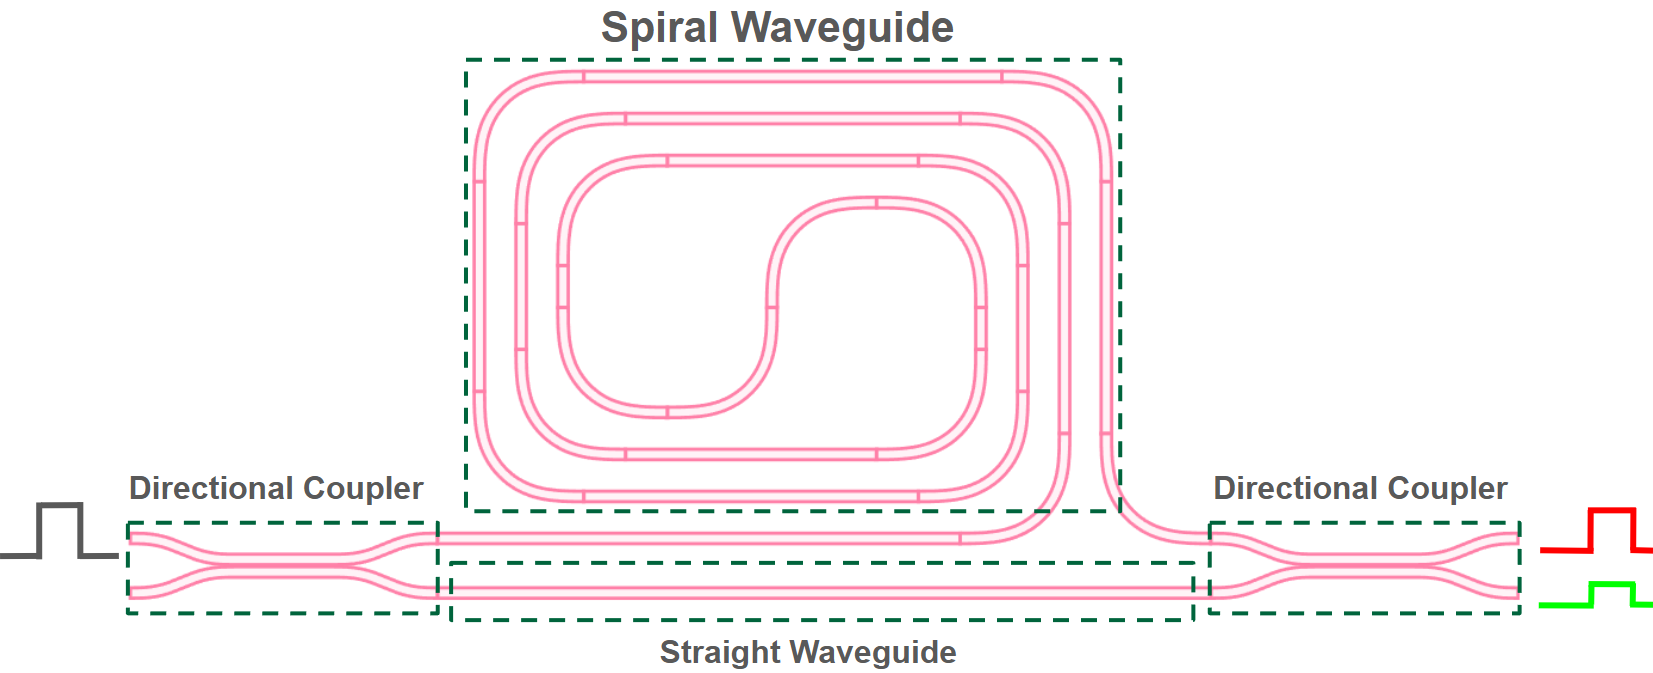



In this notebook, we design and simulate a **passive Mach–Zehnder Interferometer (MZI)** in the time domain. This structure contains **no active modulation components**—all elements are passive, including the spiral delay line used to introduce an optical path length difference between the two arms.

The goal is to demonstrate how **PhotonForge** can perform **layout-aware time-domain simulations of passive photonic circuits** with minimal user effort.  
By simply calling the time-stepper once on the assembled MZI, PhotonForge automatically:

1. Computes the **frequency-domain S‑matrix** of each component (using analytical models or full-wave solvers like Tidy3D).
2. Generates a **pole–residue fit** for each response to enable efficient time-domain evaluation.
3. Propagates the input waveforms through the circuit to obtain the output signals.

This workflow requires **no manual fitting or convolution code**—PhotonForge handles the entire process internally.

In [1]:
import numpy as np
import photonforge as pf
import siepic_forge as siepic_pdk
from matplotlib import pyplot as plt

We begin by setting up the **default technology**, **component parameters** and **frequencies** for our MZI simulation. 

In [2]:
# Set the default technology to SiEPIC OpenEBL
pf.config.default_technology = siepic_pdk.ebeam()

# Define default keyword arguments for all components
pf.config.default_kwargs = {
    "radius": 5,  # default bend radius in microns
    "euler_fraction": 0.5,  # fraction of bend length as Euler curve
    "port_spec": "TE_1550_500",  # default port specification (waveguide type)
}

# Define the optical carrier frequency (around 1550 nm wavelength)
f_c = 193.4e12  # Hz

# Define the electrical modulation frequency
f_m = 10e9  # Hz

## Directional Coupler

We create a **directional coupler** using an S-bend geometry with specified coupling distance, length, and offset parameters, designed for 50% coupling efficiency at 1550 nm wavelength. We also add [the analytical built-in](../_autosummary/photonforge.DirectionalCouplerModel.rst) `DirectionalCouplerModel` model for the coupler to enable efficient circuit-level simulations without full-field computation.


In [3]:
# Create a parametric S-bend directional coupler
directional_coupler = pf.parametric.s_bend_coupler(
    coupling_distance=0.6,  # gap between coupling waveguides (µm)
    coupling_length=4.7,  # length of coupling region (µm)
    s_bend_length=5,  # length of S-bend transition (µm)
    s_bend_offset=1,  # lateral offset of S-bend (µm)
)

# Define symmetry relations for Tidy3D simulation
directional_coupler.models["Tidy3D"].port_symmetries = [
    ("P1", "P0", "P3", "P2"),  # reflection across x-axis
    ("P2", "P3", "P0", "P1"),  # reflection across y-axis
    ("P3", "P2", "P1", "P0"),  # inversion symmetry
]

# Add analytical model for faster circuit simulations
directional_coupler.add_model(pf.DirectionalCouplerModel(), "Analytical Model")

# Display the coupler
directional_coupler

Then, we define a **rectangular spiral** with 7 turns, aligned along the y-axis:


In [4]:
spiral = pf.parametric.rectangular_spiral(turns=7, align_ports="y")
spiral

and a straight waveguide to match the spiral length minus the modulator length.

In [5]:
wg = pf.parametric.straight(length=spiral.size()[0])
wg

## MZI Assembly


We now integrate the previously defined components to construct the full **MZI**. External ports are collected from the two couplers and the modulator’s electrical control port, making it possible to inject optical signals and apply modulation voltage. A `CircuitModel` is added so that PhotonForge can simulate the device as a network of interconnected subcomponents in the time domain. This completes the layout and connectivity for our MZI, ready for time-domain simulation with optical and electrical inputs.


In [6]:
# Define netlist for assembling the tunable photonic unit
netlist_mzi = {
    "name": "MZI",
    "instances": {
        "dc0": directional_coupler,  # input coupler
        "spiral": spiral,
        "wg": wg,
        "dc1": directional_coupler,  # output coupler
    },
    # Explicitly define connections between component ports
    "connections": [
        (("wg", "P0"), ("dc0", "P2")),
        (("dc1", "P0"), ("wg", "P1")),
        (("spiral", "P0"), ("dc0", "P3")),
    ],
    # Define external ports of the tunable unit
    "ports": [("dc0", "P0"), ("dc0", "P1"), ("dc1", "P2"), ("dc1", "P3")],
    # Assign circuit model to the assembled unit
    "models": [(pf.CircuitModel(), "Circuit")],
}

# Create a photonic component from the defined netlist
mzi = pf.component_from_netlist(netlist_mzi)

# Visualize the assembled tunable unit
mzi

## Time-Stepper Initialization

One of the key advantages of PhotonForge is how **simple** it is for the user to set up a time-domain simulation. With just **a few lines of code** to create a `TimeStepper`, PhotonForge **magically handles all the complexity** behind the scenes:

- It computes the **frequency-domain S‑matrix** for each component in the MZI.
- It automatically generates a **pole–residue fit** of these responses.
- It prepares the **time-domain solver** that will propagate the input waveforms through the MZI.

The user only needs to provide:
- The desired `time_step` 
- The optical `carrier_frequency` 
- A **frequency sweep** range for spectral fitting

Once this is done, the simulation engine is fully initialized and ready to evolve the optical fields through the MZI over time—**no manual fitting, no extra setup**.


In [7]:
# Choose a time step small enough to resolve the modulation period
time_step = 0.001 / f_m

# Create a time-stepper for the MZI with the given simulation parameters
ts = mzi.setup_time_stepper(
    time_step=time_step,
    carrier_frequency=f_c,
    time_stepper_kwargs={
        "frequencies": np.linspace(f_c - 200 * f_m, f_c + 200 * f_m, 100)
    },
)

Loading cached simulation from .tidy3d/pf_cache/L3M/ms_info-EOPN3HGFTNAF45CHOW5APKKAFTV5TCO2IR2SEA5377VZ56EHVNEQ.json.
Loading cached simulation from .tidy3d/pf_cache/B75/ms_info-ZTMMYLSH4WJGHIKDBL6ULUW5TEEXX5UKS6ZTSAD42TZMUYN6SXPA.json.
Loading cached simulation from .tidy3d/pf_cache/G64/ms_info-6REAIQY4P6UMVBAHGL7J3NIHZLLP3Y6GGNTIKZITE2S252KEDYEQ.json.


Loading cached simulation from .tidy3d/pf_cache/CUE/ms_info-C7O4VGXYTVXJFSPY3FG7EJSSQL3AETANHXD4FUQIXJUSIQEYWDIQ.json.


Progress: 100% 


**Input Signal Definition**

We define the electrical and optical signals that drive the MZI during the time-domain simulation. These inputs will be used by the time-stepper to propagate signals through the MZI.


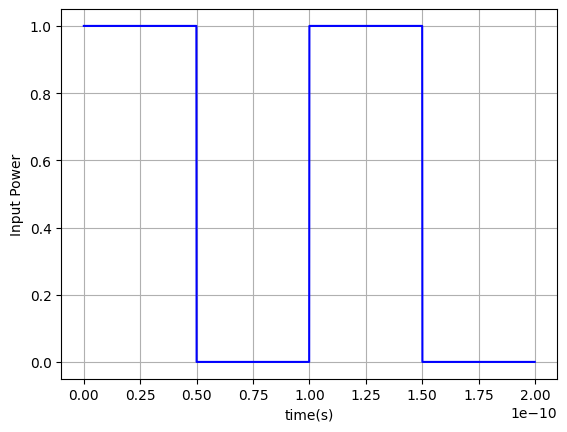

In [8]:
# Simulation grid
N_steps = 2000
t = time_step * np.arange(N_steps)

# RZ digital signal parameters
bit_rate = f_m
bit_period = 1 / bit_rate
duty_cycle = 0.5
pulse_width = duty_cycle * bit_period  # high-level duration

# time within each bit
τ = t % bit_period

# Build waveform
rz = np.zeros_like(t)
rz[τ < pulse_width] = 1.0

# Package into TimeSeries
A0_in = np.zeros_like(t)
A1_in = rz

inputs = pf.TimeSeries(
    values={
        "P0@0": A0_in,
        "P1@0": A1_in,
    },
    time_step=time_step,
)

plt.plot(t, np.abs(A1_in) ** 2, color="blue")
plt.ylabel("Input Power")
plt.xlabel("time(s)")
plt.grid()
plt.show()

## Running the Time-Domain Simulation

- **Resetting the Time-Stepper**  
  We call `ts.reset` to ensure the simulation starts with a clean internal state, preventing residual values from previous runs.

- **Executing the Simulation**  
  The `step` method of the time-stepper is used to propagate the defined optical and electrical inputs through the MZI over the simulation time, producing the output waveforms.

The resulting `outputs` object contains the simulated time-domain signals at all output ports of the MZI.


In [9]:
# Reset the time-stepper to ensure a clean simulation start
ts.reset()

# Run the simulation for the given input waveforms
outputs = ts.step(inputs)

Progress: 2000/2000


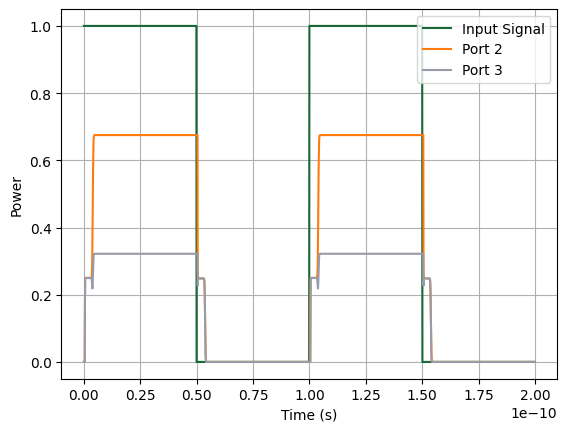

In [10]:
# Plot PhotonForge simulation results for both output ports
plt.plot(t, np.abs(A1_in) ** 2, label="Input Signal")
plt.plot(t, np.abs(outputs["P2@0"]) ** 2, label="Port 2")
plt.plot(t, np.abs(outputs["P3@0"]) ** 2, label="Port 3")

# Labels and legend
plt.xlabel("Time (s)")
plt.ylabel("Power")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

### Interpreting the Time-Domain Output

At the very start, the outputs are almost **identical**, showing only a small shift due to the short delay through the straight arm.  
This is why both outputs track each other right after the input changes.

Once the signal traveling through the **spiral delay line** arrives—after a **larger delay**—the two optical paths recombine with a **relative phase difference**.  
This phase difference causes **interference**, leading to the characteristic constructive and destructive output pattern of an MZI.

**Important:** In this example the instantaneous phase difference $\Delta\phi(t)$ is **not exactly** $0$ or $\pi$, so we do **not** observe full transmission or perfect extinction. Instead, the outputs settle at partial contrast:
$P_2 \propto 1 + \cos\Delta\phi,\quad P_3 \propto 1 - \cos\Delta\phi,$

In summary:
1. **Small initial delay** → outputs look the same.
2. **Larger spiral-induced delay** → interference starts, splitting power between the two output ports, with **partial** (not complete) constructive/destructive interference.


## Activating Tidy3D for High-Accuracy Simulation

We switch the **directional coupler** and **spiral bends** to use their **Tidy3D full-wave models**, enabling more accurate simulations that capture electromagnetic effects beyond analytical approximations.



In [11]:
# Use Tidy3D model for bends inside spiral
spiral.update(bend_kwargs={"active_model": "Tidy3D"})

# Use Tidy3D model for directional coupler
directional_coupler.activate_model("Tidy3D")

.venv/photonforge/lib/python3.13/site-packages/photonforge/parametric.py:1672: RuntimeWarning: Arguments 'active_model', 'tidy3d_model_kwargs', and 'waveguide_model_kwargs' are deprecated. Please use argument 'model' instead.
  bend0 = _bend(**bend_kwargs)
.venv/photonforge/lib/python3.13/site-packages/photonforge/parametric.py:1674: RuntimeWarning: Arguments 'active_model', 'tidy3d_model_kwargs', and 'waveguide_model_kwargs' are deprecated. Please use argument 'model' instead.
  bend1 = _bend(**bend_kwargs)


Tidy3DModel(run_time=None, medium=None, symmetry=(0, 0, 0), boundary_spec=None, monitors=(), structures=(), grid_spec=None, shutoff=None, subpixel=None, courant=None, port_symmetries=(), bounds=((None, None, None), (None, None, None)), source_gap=None, simulation_updates={}, verbose=True)

After activating the high-fidelity models, we re-initialize the MZI's **time-stepper** for time-domain simulation. We also reduce `rms_error_tolerance` to suppress warnings that occur when the pole-residue fit error exceeds this value. While increasing the Tidy3D simulation accuracy would also prevent this warning, the current setting provides sufficient accuracy for the final results.

In [12]:
# Setting rms_error_tolerance for pole-residue fit
pf.config.default_time_steppers['*'] = pf.SMatrixTimeStepper(rms_error_tolerance=0.001)

# Set up time stepper
ts_td = mzi.setup_time_stepper(
    time_step=time_step,
    carrier_frequency=f_c,
    time_stepper_kwargs={
        "frequencies": np.linspace(f_c - 200 * f_m, f_c + 200 * f_m, 100),
    },
)

# Reset the time-stepper to ensure a clean simulation start
ts_td.reset()

# Run the simulation for the given input waveforms
outputs_td = ts_td.step(inputs)

Progress: 100% 


Progress: 2000/2000


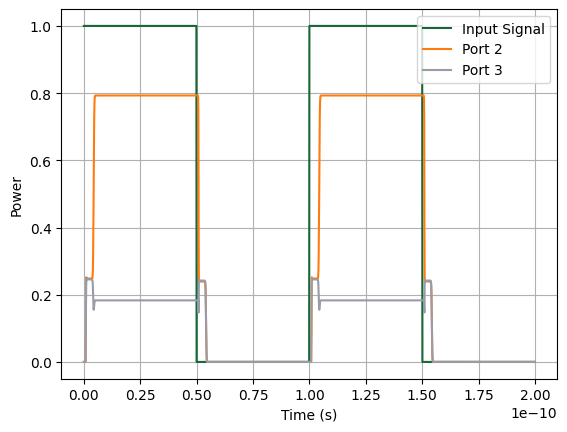

In [13]:
plt.plot(t, np.abs(A1_in) ** 2, label="Input Signal")
plt.plot(t, np.abs(outputs_td["P2@0"]) ** 2, label="Port 2")
plt.plot(t, np.abs(outputs_td["P3@0"]) ** 2, label="Port 3")

# Labels and legend
plt.xlabel("Time (s)")
plt.ylabel("Power")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

**Why Do the Time-Domain Results Differ Between the Analytic and Tidy3D Models?**

When using the **Tidy3D** model for bends, the full-wave solver captures subtle effects that are **not included in the analytic bend model**.  
In particular, the **effective index** in the bend region differs slightly from that of a straight waveguide, which changes the **optical phase accumulated** along each arm of the MZI.

These phase changes lead to:
- A **shift in the interference spectrum** of the MZI.
- Corresponding changes in the **S-matrix** at a given frequency (both phase and amplitude can be affected).
- A different **time-domain output waveform** when driven with the same input.
